In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from datetime import datetime
import seaborn as sns
%matplotlib inline

In [2]:
weather=pd.read_csv('austin_weather.csv').drop(['DewPointHighF','DewPointLowF','HumidityHighPercent','HumidityLowPercent',
                                               'SeaLevelPressureHighInches','SeaLevelPressureLowInches','VisibilityHighMiles',
                                               'VisibilityLowMiles','WindHighMPH','WindGustMPH','HumidityAvgPercent'],1)
trips=pd.read_csv('austin_bikeshare_trips.csv')
station=pd.read_csv('austin_bikeshare_stations_w_zipcode.csv')
weather.head()

,Date,TempHighF,TempAvgF,TempLowF,DewPointAvgF,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,49,29.68,7,4,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,36,30.13,10,6,0,
2,2013-12-23,58,45,32,27,30.49,10,3,0,
3,2013-12-24,61,46,31,28,30.45,10,4,0,
4,2013-12-25,58,50,41,40,30.33,10,2,T,


In [3]:
weather.Events.unique()
weather['Rain']=np.where(weather.Events.str.contains('Rain'), 1, 0)
weather.Date=pd.to_datetime(weather.Date)
weather=weather.set_index('Date').drop('Events',1)

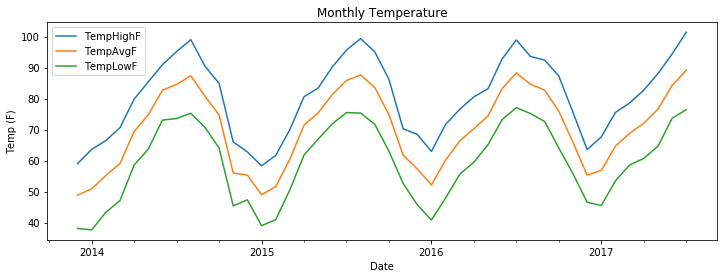

In [4]:
weather[['TempHighF', 'TempAvgF', 'TempLowF']].resample('M').mean().plot(title='Monthly Temperature', figsize=(12,4))
plt.ylabel('Temp (F)')
plt.show()

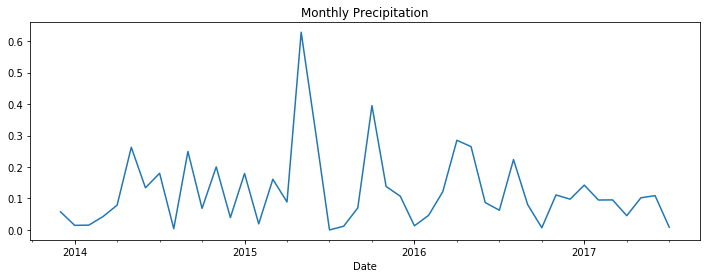

In [5]:
weather['PrecipitationSumInches']=pd.to_numeric(weather['PrecipitationSumInches'],errors='coerce')
weather['PrecipitationSumInches'].resample('M').mean().plot(title='Monthly Precipitation', figsize=(12, 4))
plt.show()

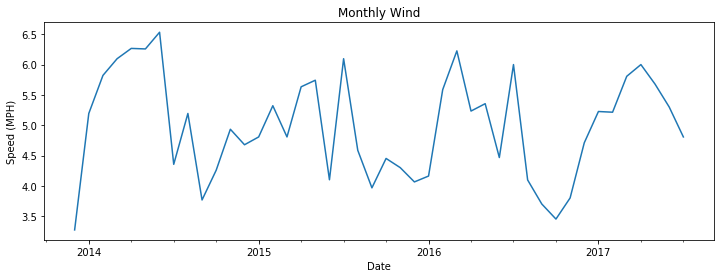

In [6]:
weather['WindAvgMPH']=pd.to_numeric(weather['WindAvgMPH'],errors='coerce')
weather['WindAvgMPH'].resample('M').mean().plot(title='Monthly Wind', figsize=(12,4))
plt.ylabel('Speed (MPH)')
plt.show()

In [7]:
ind = pd.DatetimeIndex(trips.start_time)
trips['Date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour
by_date = trips.pivot_table('trip_id', aggfunc='count',index='Date',columns='subscriber_type', )
by_date = trips.groupby(['Date', 'subscriber_type'])['trip_id'].count()
by_date.name = 'count'
by_date = by_date.reset_index('subscriber_type')
trips_2=trips[trips.year.isin([2014,2015,2016])]
trip_weather=trips_2.merge(weather,left_on='Date',right_on='Date',
                         suffixes=['_trips','_weather']).drop(['SeaLevelPressureAvgInches'],1)
trip_weather=trip_weather.drop(['DewPointAvgF','VisibilityAvgMiles','end_station_id','end_station_name','bikeid',
                                'TempHighF','TempLowF'],1)

In [8]:
trip_weather.head()

,checkout_time,duration_minutes,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year,Date,hour,TempAvgF,WindAvgMPH,PrecipitationSumInches,Rain
0,19:12:00,41,3.0,2536.0,Waller & 6th St.,2015/3/19 19:12,Walk Up,9900082882,2015.0,2015-03-19,19,73,5.0,0.0,0
1,16:12:00,22,3.0,2499.0,City Hall / Lavaca & 2nd,2015/3/19 16:12,Walk Up,9900082182,2015.0,2015-03-19,16,73,5.0,0.0,0
2,20:12:00,29,3.0,2563.0,Davis at Rainey Street,2015/3/19 20:12,Walk Up,9900083166,2015.0,2015-03-19,20,73,5.0,0.0,0
3,15:12:00,31,3.0,2711.0,Barton Springs @ Kinney Ave,2015/3/19 15:12,Walk Up,9900081791,2015.0,2015-03-19,15,73,5.0,0.0,0
4,17:12:00,247,3.0,2575.0,Riverside @ S. Lamar,2015/3/19 17:12,Walk Up,9900082453,2015.0,2015-03-19,17,73,5.0,0.0,0


## correlation matrix of weather

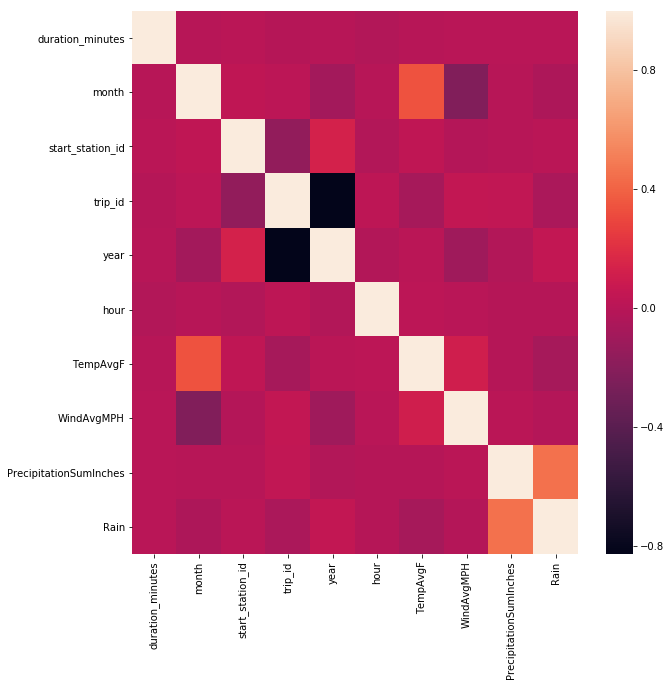

In [9]:
correlation=trip_weather.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation, ax=ax)

## weather effects to station

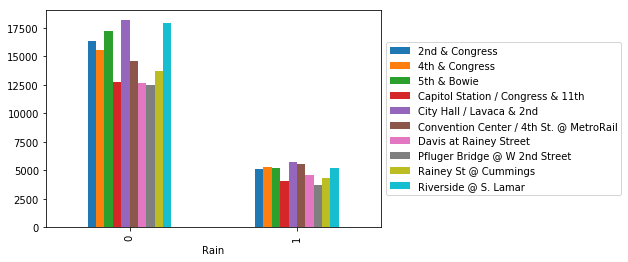

In [10]:
rain_station=trip_weather.groupby('Rain')['start_station_name'].apply(lambda x:x.value_counts().head(10))
temp_station=trip_weather.groupby('TempAvgF')['start_station_name'].apply(lambda x:x.value_counts().head(10))
rain_station.unstack().plot(kind='bar')
plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5))

## Rain effects on rider counts based on seasons, stations and membership

In [11]:
trip_weather.loc[trip_weather['month'].isin([3,4,5]), 'season'] = 'Spring'
trip_weather.loc[trip_weather['month'].isin([6,7,8]), 'season'] = 'Summer'
trip_weather.loc[trip_weather['month'].isin([9,10,11]), 'season'] = 'Fall'
trip_weather.loc[trip_weather['month'].isin([12,1,2]), 'season'] = 'Winter'

In [12]:
rain_season=trip_weather.groupby(['season','Rain'])['trip_id'].count().unstack()
rain_season['percentage drop']=(rain_season[0]-rain_season[1])/rain_season[0]
rain_season

Rain,0,1,percentage drop
season,,,
Fall,115087,34766,0.697915
Spring,106176,60758,0.427761
Summer,109199,19854,0.818185
Winter,66020,13044,0.802424


In [37]:
rain_station=trip_weather.groupby(['start_station_name','Rain'])['trip_id'].count().unstack()
rain_station['percentage drop']=(rain_station[0]-rain_station[1])/rain_station[0]
rain_station[rain_station[0]>=1000].sort_values(0,ascending=False).head()
# 70% decrease of people who ride bikes in rainy days
# not obvious pattern between stations

Rain,0,1,percentage drop
start_station_name,,,
Riverside @ S. Lamar,17187.0,5042.0,0.706639
City Hall / Lavaca & 2nd,16841.0,5383.0,0.680363
5th & Bowie,15926.0,4838.0,0.696220
2nd & Congress,15405.0,4764.0,0.690750
4th & Congress,14170.0,4928.0,0.652223


In [54]:
trip_weather_member=trip_weather[trip_weather['year'].isin([2015,2016,2017])]
rain_membership=trip_weather_member.groupby(['subscriber_type','Rain'])['trip_id'].count().unstack()
rain_membership
rain_membership['percentage drop']=(rain_membership[0]-rain_membership[1])/rain_membership[0]
rain_membership.sort_values('percentage drop',ascending=False)

Rain,0,1,percentage drop
subscriber_type,,,
Local30,19102,6108,0.680243
Local365,69848,23129,0.668867
Walk Up,162082,56434,0.651818
Weekender,8985,3429,0.618364


## Temperature effects on rider counts based on seasons, stations and membership

In [42]:
trip_weather['Temp']='Medium Temp'
trip_weather.loc[trip_weather['TempAvgF']>=80,'Temp']='High Temp'
trip_weather.loc[trip_weather['TempAvgF']<=59,'Temp']='Low Temp'

In [57]:
temperature=trip_weather.groupby('Temp')['trip_id'].count()
temperature['percent drop in hot days']=(temperature['Medium Temp']-temperature['High Temp'])/float(temperature['Medium Temp'])
temperature['percent drop in cold days']=(temperature['Medium Temp']-temperature['Low Temp'])/float(temperature['Medium Temp'])
temperature

Temp
High Temp                    167081.000000
Low Temp                      69323.000000
Medium Temp                  257060.000000
percent drop in hot days          0.350031
percent drop in cold days         0.730324
Name: trip_id, dtype: float64

In [45]:
temp_station=trip_weather.groupby(['start_station_name','Temp'])['trip_id'].count().unstack()
temp_station['percent drop in hot days']=(temp_station['Medium Temp']-temp_station['High Temp'])/temp_station['Medium Temp']
temp_station['percent drop in cold days']=(temp_station['Medium Temp']-temp_station['Low Temp'])/temp_station['Medium Temp']
temp_station[temp_station['Medium Temp']>=500].sort_values('Medium Temp',ascending=False).head(20)
# about 35% drop in hot days and 70% drop in cold days since Austin people are more used to the high tempearture hhhhhh

Temp,High Temp,Low Temp,Medium Temp,percent drop in hot days,percent drop in cold days
start_station_name,,,,,
City Hall / Lavaca & 2nd,7382.0,3266.0,11576.0,0.362301,0.717865
Riverside @ S. Lamar,8202.0,3009.0,11018.0,0.255582,0.726901
2nd & Congress,7034.0,2549.0,10586.0,0.335538,0.759210
5th & Bowie,7256.0,3269.0,10239.0,0.291337,0.680731
Convention Center / 4th St. @ MetroRail,5695.0,2940.0,10051.0,0.433390,0.707492
4th & Congress,6534.0,2846.0,9718.0,0.327639,0.707141
Davis at Rainey Street,4981.0,2059.0,9388.0,0.469429,0.780677
Rainey St @ Cummings,6653.0,2319.0,8356.0,0.203806,0.722475
Capitol Station / Congress & 11th,5489.0,2546.0,7848.0,0.300586,0.675586


## Temperature influence on membership

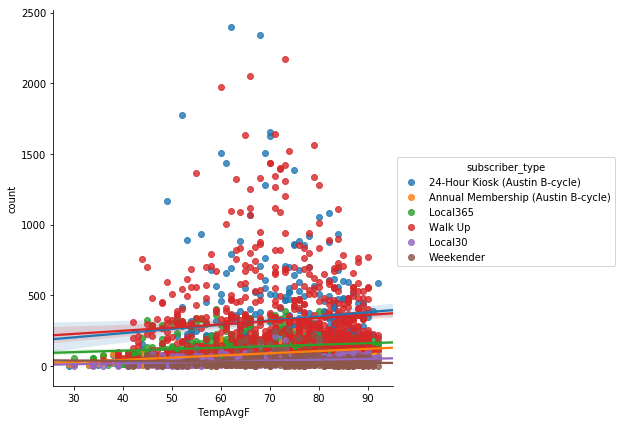

In [20]:
a=trip_weather['subscriber_type'].value_counts().head(6)
trip_weather=trip_weather[trip_weather['subscriber_type'].map(lambda x: x in a)]
trip_weather2=trip_weather.groupby(['Date', 'subscriber_type'])['trip_id'].count()
trip_weather2.name = 'count'
trip_weather2=trip_weather2.reset_index('subscriber_type').join(weather)
g = sns.FacetGrid(trip_weather2, hue='subscriber_type', size=6)
g.map(sns.regplot,"TempAvgF","count")
g.add_legend()

## Precipitation effects on membership

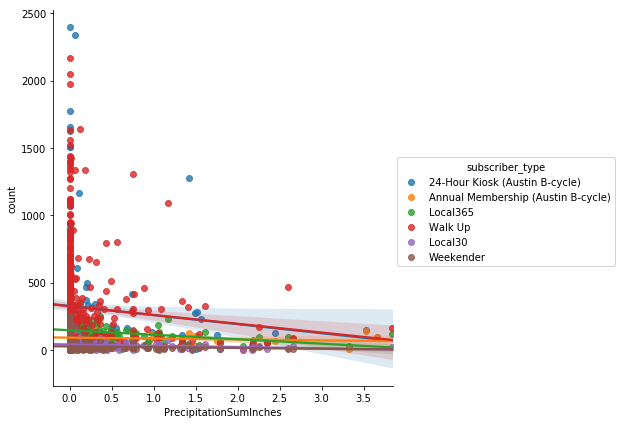

In [21]:
g = sns.FacetGrid(trip_weather2, hue='subscriber_type', size=6)
g.map(sns.regplot,"PrecipitationSumInches","count")
g.add_legend()